In [1]:
%pip install ultralytics roboflow opencv-python numpy albumentations glob2 tqdm pathlib tensorboard ipywidgets

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
   --------------------------------------- 949.2/949.2 kB 10.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   -- ------------------------------------- 2.9/38.8 MB 12.0 MB/s eta 0:00:03
   ----- ---------------------------------- 5.5/38.8 MB 12.4 MB/s eta 0:00:03
   ------- -------------------------------- 7.3/38.8 MB 11.6 MB/s eta 0:00:03
   ---------- ----------------------------- 10.0/38.8 MB 11.5 MB/s eta 0:00:03
   ------------ --------------------------- 12.3/38.8 MB 11.5 MB/s eta 0:00:03
   -------------- ------------------------- 14.4/38.8 MB 11.3 MB/s eta 0:00:03
   ----------------- ---------------------- 16.5/38.8 MB 11.4 MB/s eta 0:00:02
   ------------------- -------------------- 18.6/38.8 MB 11.1 MB/s eta 0:00:02
   --------------------- ------------------ 20.7

DEPRECATION: Loading egg at c:\users\user\appdata\local\programs\python\python312\lib\site-packages\pycocotools-2.0-py3.12-win-amd64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [ ]:
%rm -rf Machine-Learning-Project-1

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="446N9EsXjU0XqiKYEmDp")
project = rf.workspace("xinghao2003").project("machine-learning-project-kfkz7")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Machine-Learning-Project-1 in yolov8:: 100%|██████████| 372/372 [00:00<00:00, 1302.76it/s]
optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.


Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\user\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
from pathlib import Path

DATASET_PATH = Path("Machine-Learning-Project-1").absolute()
DATASET_CONFIG_PATH = Path("Machine-Learning-Project-1/data.yaml").absolute()

In [ ]:
# Data Preprocessing
# Skipped, already done using Roboflow
# Duplication removed
# Image auto oriented, and stretch to 640x640

In [ ]:
# Data Augmentation
import os
import cv2
import numpy as np
import albumentations as A
import glob
from pathlib import Path
from tqdm import tqdm
import argparse
import random


def augment_yolov8_dataset(
    dataset_path,
    augmentations_per_image=3,
    seed=42
):
    """
    Apply data augmentation to YOLOv8 dataset with polygon annotations and store
    augmented data in the same directory as the original images and labels.

    Args:
        dataset_path: Path to the YOLOv8 dataset directory
        augmentations_per_image: Number of augmented versions per original image
        seed: Random seed for reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)

    # Define paths
    train_images_path = os.path.join(dataset_path, "train", "images")
    train_labels_path = os.path.join(dataset_path, "train", "labels")

    if not os.path.exists(train_images_path) or not os.path.exists(train_labels_path):
        raise ValueError(
            f"Invalid dataset path: {dataset_path}. Expected train/images and train/labels directories.")

    # Define augmentation pipeline for polygon annotations
    transforms = A.Compose([
        # Geometric transformations
        A.OneOf([
            A.HorizontalFlip(p=0.8),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            # A.ShiftScaleRotate(
            #     shift_limit=0.1, scale_limit=0.15, rotate_limit=15, p=0.5),
            A.Affine(
                scale=(0.85, 1.15),
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                rotate=(-15, 15),
                shear={"x": (-5, 5), "y": (-5, 5)},
                p=0.5),
        ], p=0.7),

        # Color transformations
        A.OneOf([
            A.RandomBrightnessContrast(p=0.8),
            A.RandomGamma(p=0.8),
            A.HueSaturationValue(p=0.7),
            A.CLAHE(p=0.5),
        ], p=0.7),

        # Blur and noise
        A.OneOf([
            A.GaussNoise(p=0.6),
            A.MotionBlur(blur_limit=7, p=0.6),
            A.MedianBlur(blur_limit=5, p=0.5),
            A.GaussianBlur(blur_limit=5, p=0.5),
        ], p=0.4),

        # Weather effects
        A.OneOf([
            A.RandomShadow(p=0.6),
            A.RandomFog(p=0.5),
            A.RandomSunFlare(p=0.5),
        ], p=0.3)
    ], keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=False))

    # Get all training images
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(train_images_path, ext)))

    if not image_files:
        raise ValueError(f"No image files found in {train_images_path}")

    print(f"Found {len(image_files)} images. Generating {len(image_files) * augmentations_per_image} augmented images...")

    # Process each image
    for image_file in tqdm(image_files, desc="Augmenting images"):
        try:
            # Load image
            image = cv2.imread(image_file)
            if image is None:
                print(f"Warning: Could not read image {image_file}. Skipping.")
                continue

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Get image dimensions for keypoint normalization
            h, w = image.shape[:2]

            # Get corresponding label file
            base_name = os.path.basename(image_file)
            image_name, ext = os.path.splitext(base_name)
            label_file = os.path.join(train_labels_path, image_name + ".txt")

            # Skip if label file doesn't exist
            if not os.path.exists(label_file):
                print(f"Warning: No label file for {base_name}. Skipping.")
                continue

            # Read polygon labels
            polygons = []
            class_labels = []

            with open(label_file, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) >= 3:  # class_id followed by x,y pairs
                        class_id = int(parts[0])
                        # Convert pairs of coordinates into keypoints
                        keypoints = []
                        for i in range(1, len(parts), 2):
                            if i + 1 < len(parts):
                                x = float(parts[i])
                                y = float(parts[i + 1])
                                keypoints.append((x, y))

                        if keypoints:
                            polygons.append(keypoints)
                            class_labels.append(class_id)

            # Skip if no polygons
            if not polygons:
                print(f"Warning: No valid polygons in {label_file}. Skipping.")
                continue

            # Flatten polygons for Albumentations
            keypoints_flattened = []
            keypoint_class_labels = []
            polygon_idx = []  # Keep track of which polygon each keypoint belongs to

            for i, (polygon, class_id) in enumerate(zip(polygons, class_labels)):
                for kp in polygon:
                    keypoints_flattened.append(kp)
                    keypoint_class_labels.append(class_id)
                    polygon_idx.append(i)

            # Apply augmentation
            for aug_idx in range(augmentations_per_image):
                try:
                    transformed = transforms(
                        image=image,
                        keypoints=keypoints_flattened,
                        class_labels=keypoint_class_labels
                    )

                    transformed_image = transformed['image']
                    transformed_keypoints = transformed['keypoints']
                    transformed_class_labels = transformed['class_labels']

                    # Skip if no keypoints after augmentation
                    if len(transformed_keypoints) == 0:
                        continue

                    # Group keypoints back into polygons
                    transformed_polygons = {}
                    for kp, class_id, poly_id in zip(transformed_keypoints, transformed_class_labels, polygon_idx):
                        if poly_id not in transformed_polygons:
                            transformed_polygons[poly_id] = {
                                "points": [], "class_id": class_id}
                        transformed_polygons[poly_id]["points"].append(kp)

                    # Save augmented image directly in the same folder as original images
                    aug_image_name = f"{image_name}_aug_{aug_idx}{ext}"
                    aug_image_path = os.path.join(train_images_path, aug_image_name)
                    cv2.imwrite(aug_image_path, cv2.cvtColor(
                        transformed_image, cv2.COLOR_RGB2BGR))

                    # Save augmented labels directly in the same folder as original labels
                    aug_label_path = os.path.join(train_labels_path, f"{image_name}_aug_{aug_idx}.txt")
                    with open(aug_label_path, 'w') as f:
                        for poly_id, poly_data in transformed_polygons.items():
                            line = str(poly_data["class_id"])
                            for x, y in poly_data["points"]:
                                # Ensure values are within valid range
                                x = max(0.0, min(1.0, x))
                                y = max(0.0, min(1.0, y))
                                line += f" {x} {y}"
                            f.write(line + "\n")

                except Exception as e:
                    print(f"Error during augmentation: {str(e)}")
                    continue

        except Exception as e:
            print(f"Error processing {image_file}: {str(e)}")

    print("Data augmentation completed successfully!")
    print(f"Augmented images saved alongside original images in: {train_images_path}")
    print(f"Augmented labels saved alongside original labels in: {train_labels_path}")

augment_yolov8_dataset(
    dataset_path=DATASET_PATH,
    augmentations_per_image=6,
    seed=42
)

Found 126 images. Generating 756 augmented images...


Augmenting images: 100%|██████████| 126/126 [00:45<00:00,  2.77it/s]

Data augmentation completed successfully!
Augmented images saved alongside original images in: /content/Machine-Learning-Project-1/train/images
Augmented labels saved alongside original labels in: /content/Machine-Learning-Project-1/train/labels


In [ ]:
# !find /content/Machine-Learning-Project-1/train/images -type f | wc -l

882


In [ ]:
from ultralytics import YOLO

# Load a YOLOv11 segmentation model
# load a pretrained model (recommended for training)
model = YOLO('yolo11n-seg.pt')

# Train the model with your dataset
# Some random augmentation being apply by default
results = model.train(
    data=DATASET_CONFIG_PATH,
    epochs=300, #number of training cycles
    patience=50,
    imgsz=640,
    batch=32,
    cache=True,
    seed=42,
    plots=True,
    save=True
)

Ultralytics 8.3.90 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=/content/Machine-Learning-Project-1/data.yaml, epochs=500, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

train: Scanning /content/Machine-Learning-Project-1/train/labels.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/Machine-Learning-Project-1/train/images/Rice-Chicken-Vegetable-18-_jpeg_jpg.rf.7d55ce4b2ec45bc531d0a972faa6038a_aug_4.jpg: 2 duplicate labels removed
train: WARNING ⚠️ /content/Machine-Learning-Project-1/train/images/Rice-Chicken-Vegetable-30-_jpeg_jpg.rf.5747b678a3772171538eed0a496d51a1_aug_3.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Machine-Learning-Project-1/train/images/Rice-Chicken-Vegetable-30-_jpeg_jpg.rf.5747b678a3772171538eed0a496d51a1_aug_5.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Machine-Learning-Project-1/train/images/Rice-Chicken-Vegetable-33-_jpeg_jpg.rf.6d23d27ec520428aa76d98771ad04a9d_aug_0.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/Machine-Learning-Project-1/train/images/Rice-Chicken-Vegetable-8-_jpeg_jpg.rf.d415cb65b5966eb899d2cb96d3eba224_aug_1.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Machine-Learning-Project-1/train/images/Rice-Chicken-Vegetable-8-_jpeg_jpg.rf.d415cb65b59


train: Caching images (1.0GB RAM): 100%|██████████| 882/882 [00:03<00:00, 243.83it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.74G total, 3.69G reserved, 0.29G allocated, 10.76G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2843778       10.36         0.958         36.44           nan        (1, 3, 640, 640)                    list
     2843778       20.72         1.539         36.64           nan        (2, 3, 640, 640)                    list
     2843778       41.44         2.307         36.59           nan        (4, 3, 640, 640)                    list
     2843778       82.89         3.850         40.65           nan        (8, 3, 640, 640)                    list
     2843778       165.8         6.856         67.75           nan       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 16 for CUDA:0 10.47G/14.74G (71%) ✅


train: Scanning /content/Machine-Learning-Project-1/train/labels.cache... 882 images, 0 backgrounds, 0 corrupt: 100%|██████████| 882/882 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/Machine-Learning-Project-1/train/images/Rice-Chicken-Vegetable-18-_jpeg_jpg.rf.7d55ce4b2ec45bc531d0a972faa6038a_aug_4.jpg: 2 duplicate labels removed
train: WARNING ⚠️ /content/Machine-Learning-Project-1/train/images/Rice-Chicken-Vegetable-30-_jpeg_jpg.rf.5747b678a3772171538eed0a496d51a1_aug_3.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Machine-Learning-Project-1/train/images/Rice-Chicken-Vegetable-30-_jpeg_jpg.rf.5747b678a3772171538eed0a496d51a1_aug_5.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Machine-Learning-Project-1/train/images/Rice-Chicken-Vegetable-33-_jpeg_jpg.rf.6d23d27ec520428aa76d98771ad04a9d_aug_0.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /content/Machine-Learning-Project-1/train/images/Rice-Chicken-Vegetable-8-_jpeg_jpg.rf.d415cb65b5966eb899d2cb96d3eba224_aug_1.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /content/Machine-Learning-Project-1/train/images/Rice-Chicken-Vegetable-8-_jpeg_jpg.rf.d415cb65b59


train: Caching images (1.0GB RAM): 100%|██████████| 882/882 [00:03<00:00, 260.06it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/Machine-Learning-Project-1/valid/labels.cache... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 36/36 [00:00<00:00, 105.13it/s]


Plotting labels to runs/segment/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train2
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/500      3.24G     0.9015      2.873      3.291      1.338         10        640: 100%|██████████| 56/56 [00:23<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         36        164     0.0365      0.832      0.288      0.169     0.0348       0.78       0.24      0.132



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/500      3.84G     0.8988      2.057      2.355      1.294          8        640: 100%|██████████| 56/56 [00:22<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         36        164      0.507      0.147      0.244      0.115      0.466      0.136      0.188     0.0931



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/500      3.84G     0.8898      2.008      1.978      1.279          8        640: 100%|██████████| 56/56 [00:21<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         36        164      0.467      0.402      0.302      0.158      0.449      0.325      0.258      0.112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/500      3.84G      0.871      1.952      1.782      1.259         13        640: 100%|██████████| 56/56 [00:22<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         36        164      0.515      0.282      0.269      0.125      0.401      0.234      0.209     0.0822



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/500      3.84G     0.8246      1.858      1.639      1.223         11        640: 100%|██████████| 56/56 [00:20<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         36        164      0.577      0.351       0.37      0.219      0.574      0.318      0.333      0.189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/500      3.84G     0.8102      1.828       1.57      1.221         13        640: 100%|██████████| 56/56 [00:21<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         36        164      0.412      0.307      0.282      0.151      0.409      0.282      0.245      0.125



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/500      3.84G     0.7797      1.747      1.505      1.201         19        640: 100%|██████████| 56/56 [00:21<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         36        164      0.486      0.379      0.305      0.161      0.443      0.336      0.233      0.117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/500      3.84G     0.7862      1.739       1.46      1.198         15        640: 100%|██████████| 56/56 [00:21<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         36        164      0.482      0.319      0.352      0.218      0.442      0.279      0.301      0.148



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/500      3.84G     0.7329      1.615      1.356      1.152          9        640: 100%|██████████| 56/56 [00:21<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         36        164      0.631      0.365      0.359      0.198      0.453      0.362      0.298       0.17



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/500      3.84G     0.7185      1.597      1.287      1.158         11        640: 100%|██████████| 56/56 [00:21<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         36        164      0.578      0.431      0.444      0.236      0.541      0.382      0.374      0.185



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/500      3.84G     0.6899      1.527      1.259       1.14          5        640: 100%|██████████| 56/56 [00:21<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         36        164       0.61      0.399      0.426       0.26      0.515      0.392      0.362      0.216



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/500      3.84G     0.7069      1.546      1.244      1.146          8        640: 100%|██████████| 56/56 [00:21<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         36        164      0.615      0.461       0.44      0.277      0.554      0.428      0.398      0.237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/500      3.84G     0.7009       1.51      1.219      1.143          6        640: 100%|██████████| 56/56 [00:21<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         36        164      0.585      0.356      0.427      0.254      0.525       0.35      0.407      0.227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/500      3.84G      0.661      1.475      1.118      1.112         18        640: 100%|██████████| 56/56 [00:21<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         36        164      0.557      0.396      0.384      0.234      0.517      0.383      0.337      0.197



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/500      3.84G     0.6513      1.463        1.1      1.124          4        640: 100%|██████████| 56/56 [00:21<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         36        164      0.368      0.438      0.434      0.265      0.483       0.35      0.403      0.227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/500      3.84G     0.6572      1.416      1.065      1.112         12        640: 100%|██████████| 56/56 [00:21<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         36        164      0.656      0.447      0.446      0.272      0.632      0.378      0.386      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/500      3.84G      0.638      1.411      1.062      1.112          5        640: 100%|██████████| 56/56 [00:20<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         36        164      0.635       0.41      0.423      0.281      0.619      0.381      0.383      0.236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/500      3.84G     0.6301      1.382      1.077      1.093          7        640: 100%|██████████| 56/56 [00:21<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         36        164       0.57      0.465      0.441      0.289      0.545      0.429      0.396      0.242



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/500      3.84G     0.5973      1.324     0.9973      1.072         11        640: 100%|██████████| 56/56 [00:21<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         36        164      0.507      0.498      0.489      0.316      0.484      0.512      0.465      0.277



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/500      3.84G      0.605       1.28     0.9901       1.09          8        640: 100%|██████████| 56/56 [00:21<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         36        164      0.618      0.458      0.431      0.286      0.566      0.426      0.377      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/500      3.84G     0.5958      1.302     0.9803      1.069          8        640: 100%|██████████| 56/56 [00:20<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         36        164      0.544      0.228      0.327      0.223      0.523      0.215      0.301      0.182



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/500      3.84G      0.596      1.295      1.635       1.07          0        640: 100%|██████████| 56/56 [00:20<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         36        164      0.429      0.432      0.418      0.227      0.395      0.371      0.341      0.194



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/500      3.84G     0.6007      1.264     0.9624      1.078          7        640: 100%|██████████| 56/56 [00:20<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         36        164      0.463      0.461      0.425      0.285      0.455      0.449      0.395      0.237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/500      3.84G      0.591       1.28     0.9453      1.072         13        640: 100%|██████████| 56/56 [00:20<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         36        164      0.685      0.423      0.465      0.275       0.62      0.403      0.433      0.227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/500      3.84G     0.5859      1.269     0.9317      1.079          8        640: 100%|██████████| 56/56 [00:21<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         36        164      0.674      0.405      0.471      0.307      0.655      0.389      0.447      0.272



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/500      3.84G     0.5717      1.244     0.9329      1.055          2        640: 100%|██████████| 56/56 [00:21<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         36        164       0.56      0.465       0.47      0.296      0.566      0.472      0.471      0.272



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/500      3.84G     0.6028       1.26      1.179      1.074          1        640: 100%|██████████| 56/56 [00:21<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         36        164      0.413      0.461      0.437      0.285      0.417      0.439      0.398      0.242



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/500      3.84G     0.5772      1.241     0.9431       1.07          9        640: 100%|██████████| 56/56 [00:20<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]

                   all         36        164      0.725       0.34      0.351      0.215      0.681      0.285      0.279      0.184



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/500      3.84G     0.5623      1.214     0.8801      1.053         17        640: 100%|██████████| 56/56 [00:21<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         36        164      0.503      0.491      0.463      0.295      0.469       0.45      0.401      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/500      3.84G     0.5659      1.181     0.8803      1.062         12        640: 100%|██████████| 56/56 [00:21<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         36        164      0.636      0.407      0.452      0.289      0.616      0.386      0.412       0.24



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/500      3.84G     0.5508      1.203      0.863      1.051         10        640: 100%|██████████| 56/56 [00:21<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         36        164      0.634      0.356      0.383      0.258      0.632      0.343      0.355      0.222



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/500      3.84G     0.5531      1.211     0.8864      1.039          4        640: 100%|██████████| 56/56 [00:20<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         36        164      0.524      0.393      0.426      0.286      0.475      0.368      0.393      0.247



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/500      3.84G     0.5466      1.168     0.8511      1.048         13        640: 100%|██████████| 56/56 [00:21<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         36        164      0.521      0.432      0.448        0.3      0.515      0.417      0.438      0.276



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/500      3.84G     0.5443      1.161     0.8307      1.044          6        640: 100%|██████████| 56/56 [00:21<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         36        164      0.572       0.42      0.443      0.284      0.564      0.402      0.411      0.246



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/500      3.84G     0.5393      1.132     0.8549      1.041          4        640: 100%|██████████| 56/56 [00:21<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         36        164       0.68      0.449       0.48      0.332      0.685       0.45      0.458      0.276



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/500      3.84G     0.5268      1.129     0.8083      1.041         11        640: 100%|██████████| 56/56 [00:21<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         36        164      0.663      0.456      0.459       0.29      0.628      0.427      0.414      0.239



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/500      3.84G     0.5404      1.124     0.8246      1.044          7        640: 100%|██████████| 56/56 [00:21<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         36        164      0.465      0.459       0.47      0.303      0.478      0.451       0.45      0.271



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/500      3.84G     0.5313      1.133      0.832       1.04          4        640: 100%|██████████| 56/56 [00:21<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         36        164      0.673      0.469      0.473      0.316      0.611      0.405      0.403      0.257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/500      3.84G      0.536      1.111     0.8084      1.041         10        640: 100%|██████████| 56/56 [00:21<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         36        164      0.451      0.504      0.468      0.313      0.434      0.437       0.41      0.261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/500      3.84G     0.5175      1.106      0.789      1.021         10        640: 100%|██████████| 56/56 [00:20<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         36        164      0.417      0.535      0.456      0.288      0.447      0.519       0.43      0.259



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/500      3.84G     0.5256        1.1     0.7802      1.032         10        640: 100%|██████████| 56/56 [00:21<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         36        164      0.554      0.454      0.454      0.306      0.541      0.456      0.452      0.275



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/500      3.84G     0.5178      1.106     0.7772      1.029         13        640: 100%|██████████| 56/56 [00:21<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         36        164      0.524      0.362      0.413      0.274      0.513       0.35      0.384      0.243



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/500      3.84G     0.5091       1.09     0.7577      1.024          4        640: 100%|██████████| 56/56 [00:21<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         36        164        0.5       0.39      0.431      0.308      0.478      0.363      0.402      0.253



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/500      3.84G     0.5062      1.068     0.7626      1.025          5        640: 100%|██████████| 56/56 [00:20<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         36        164      0.519      0.465      0.478      0.331       0.49      0.438      0.451      0.273



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/500      3.84G     0.5266      1.112     0.8345      1.034          4        640: 100%|██████████| 56/56 [00:21<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         36        164      0.466      0.487      0.457      0.314      0.522      0.405      0.411      0.262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/500      3.84G     0.5128      1.137     0.7734      1.018          7        640: 100%|██████████| 56/56 [00:21<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         36        164      0.473      0.399      0.403       0.27      0.447      0.384       0.37      0.224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/500      3.84G     0.5003      1.075     0.7539      1.033          8        640: 100%|██████████| 56/56 [00:21<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         36        164      0.566      0.397      0.436      0.296      0.557      0.388      0.422      0.262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/500      3.84G     0.4917      1.067     0.7447       1.02         15        640: 100%|██████████| 56/56 [00:20<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         36        164      0.445      0.428      0.421      0.284      0.423      0.401      0.388      0.247



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/500      3.84G     0.5012      1.089      0.753      1.024         10        640: 100%|██████████| 56/56 [00:21<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         36        164      0.654      0.413      0.434      0.303      0.644      0.394      0.401      0.259



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/500      3.84G     0.4772      1.051     0.7122      1.004         10        640: 100%|██████████| 56/56 [00:21<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         36        164      0.547      0.495      0.487      0.334      0.509      0.536      0.467      0.302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/500      3.84G     0.4827      0.998     0.6982       1.01         11        640: 100%|██████████| 56/56 [00:21<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         36        164      0.591       0.45      0.435      0.306      0.569      0.431      0.403      0.253



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/500      3.84G     0.4839      1.022     0.7066      1.012          9        640: 100%|██████████| 56/56 [00:20<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         36        164       0.51      0.526      0.474      0.289      0.507      0.532      0.449      0.262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/500      3.84G     0.4728     0.9998     0.7044      1.007         14        640: 100%|██████████| 56/56 [00:20<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         36        164      0.465      0.446      0.432      0.303      0.468      0.447      0.408      0.255



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/500      3.84G     0.4817      1.015     0.7531      1.013          2        640: 100%|██████████| 56/56 [00:21<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         36        164      0.526       0.51      0.471      0.318      0.508      0.492      0.431      0.267



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/500      3.84G     0.4815      1.007     0.7347      1.013          9        640: 100%|██████████| 56/56 [00:21<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         36        164      0.514      0.508      0.493      0.335      0.485       0.47      0.451      0.291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/500      3.84G     0.4931      1.028     0.7409      1.017         10        640: 100%|██████████| 56/56 [00:19<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         36        164      0.584      0.464      0.488      0.317      0.553      0.439      0.438      0.276



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/500      3.84G     0.4735      0.999     0.6924      1.002         12        640: 100%|██████████| 56/56 [00:20<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         36        164      0.417      0.361      0.366      0.255      0.415       0.33      0.326      0.211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/500      3.84G     0.4587     0.9728     0.6674     0.9943         13        640: 100%|██████████| 56/56 [00:21<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         36        164      0.488        0.4        0.4      0.269      0.499      0.389      0.375      0.236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/500      3.84G     0.4885     0.9934     0.6957      1.017          4        640: 100%|██████████| 56/56 [00:21<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         36        164      0.469      0.443      0.424      0.298      0.456      0.425      0.396      0.251



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/500      3.84G     0.4701     0.9904     0.6941     0.9949          8        640: 100%|██████████| 56/56 [00:20<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         36        164      0.559      0.411      0.429      0.283       0.53      0.374      0.411      0.244



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/500      3.84G     0.4684     0.9587     0.6813      1.006          5        640: 100%|██████████| 56/56 [00:21<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

                   all         36        164      0.475      0.413       0.42       0.29      0.516      0.385      0.408      0.253



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/500      3.84G      0.477     0.9582     0.6863      1.009         10        640: 100%|██████████| 56/56 [00:21<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         36        164      0.552      0.401      0.427      0.298      0.543      0.386      0.409      0.265



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/500      3.84G     0.4637      1.017     0.6651      1.001         65        640:  45%|████▍     | 25/56 [00:09<00:12,  2.57it/s]

In [ ]:
from ultralytics import YOLO

# Load a YOLOv11 segmentation model
# load a pretrained model (recommended for training)
model = YOLO('yolo11n-seg.pt')

# Auto hyperparameter tuning for 10 rounds
results = model.tune(
    data=DATASET_CONFIG_PATH,
    epochs=300,
    patience=50,
    imgsz=640,
    batch=32,
    cache=True,
    seed=42,
    plots=True,
    save=True
)

Tuner: Initialized Tuner instance with 'tune_dir=runs/segment/train23'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}
Saved runs/segment/train23/tune_scatter_plots.png
Saved runs/segment/train23/tune_fitness.png

Tuner: 1/10 iterations complete ✅ (2033.82s)
Tuner: Results saved to runs/segment/train23
Tuner: Best fitness=0.79998 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.52874, 'metrics/recall(B)': 0.62964, 'metrics/mAP50(B)': 0.55666, 'metrics/mAP50-95(B)': 0.41137, 'metrics/precision(M)': 0

KeyboardInterrupt: 


image 1/1 /content/WhatsApp Image 2025-03-12 at 11.35.44_c26cb5e6.jpg: 640x480 1 Chicken, 2 Plates, 1 Rice, 1 Vegetables, 45.4ms
Speed: 4.4ms preprocess, 45.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


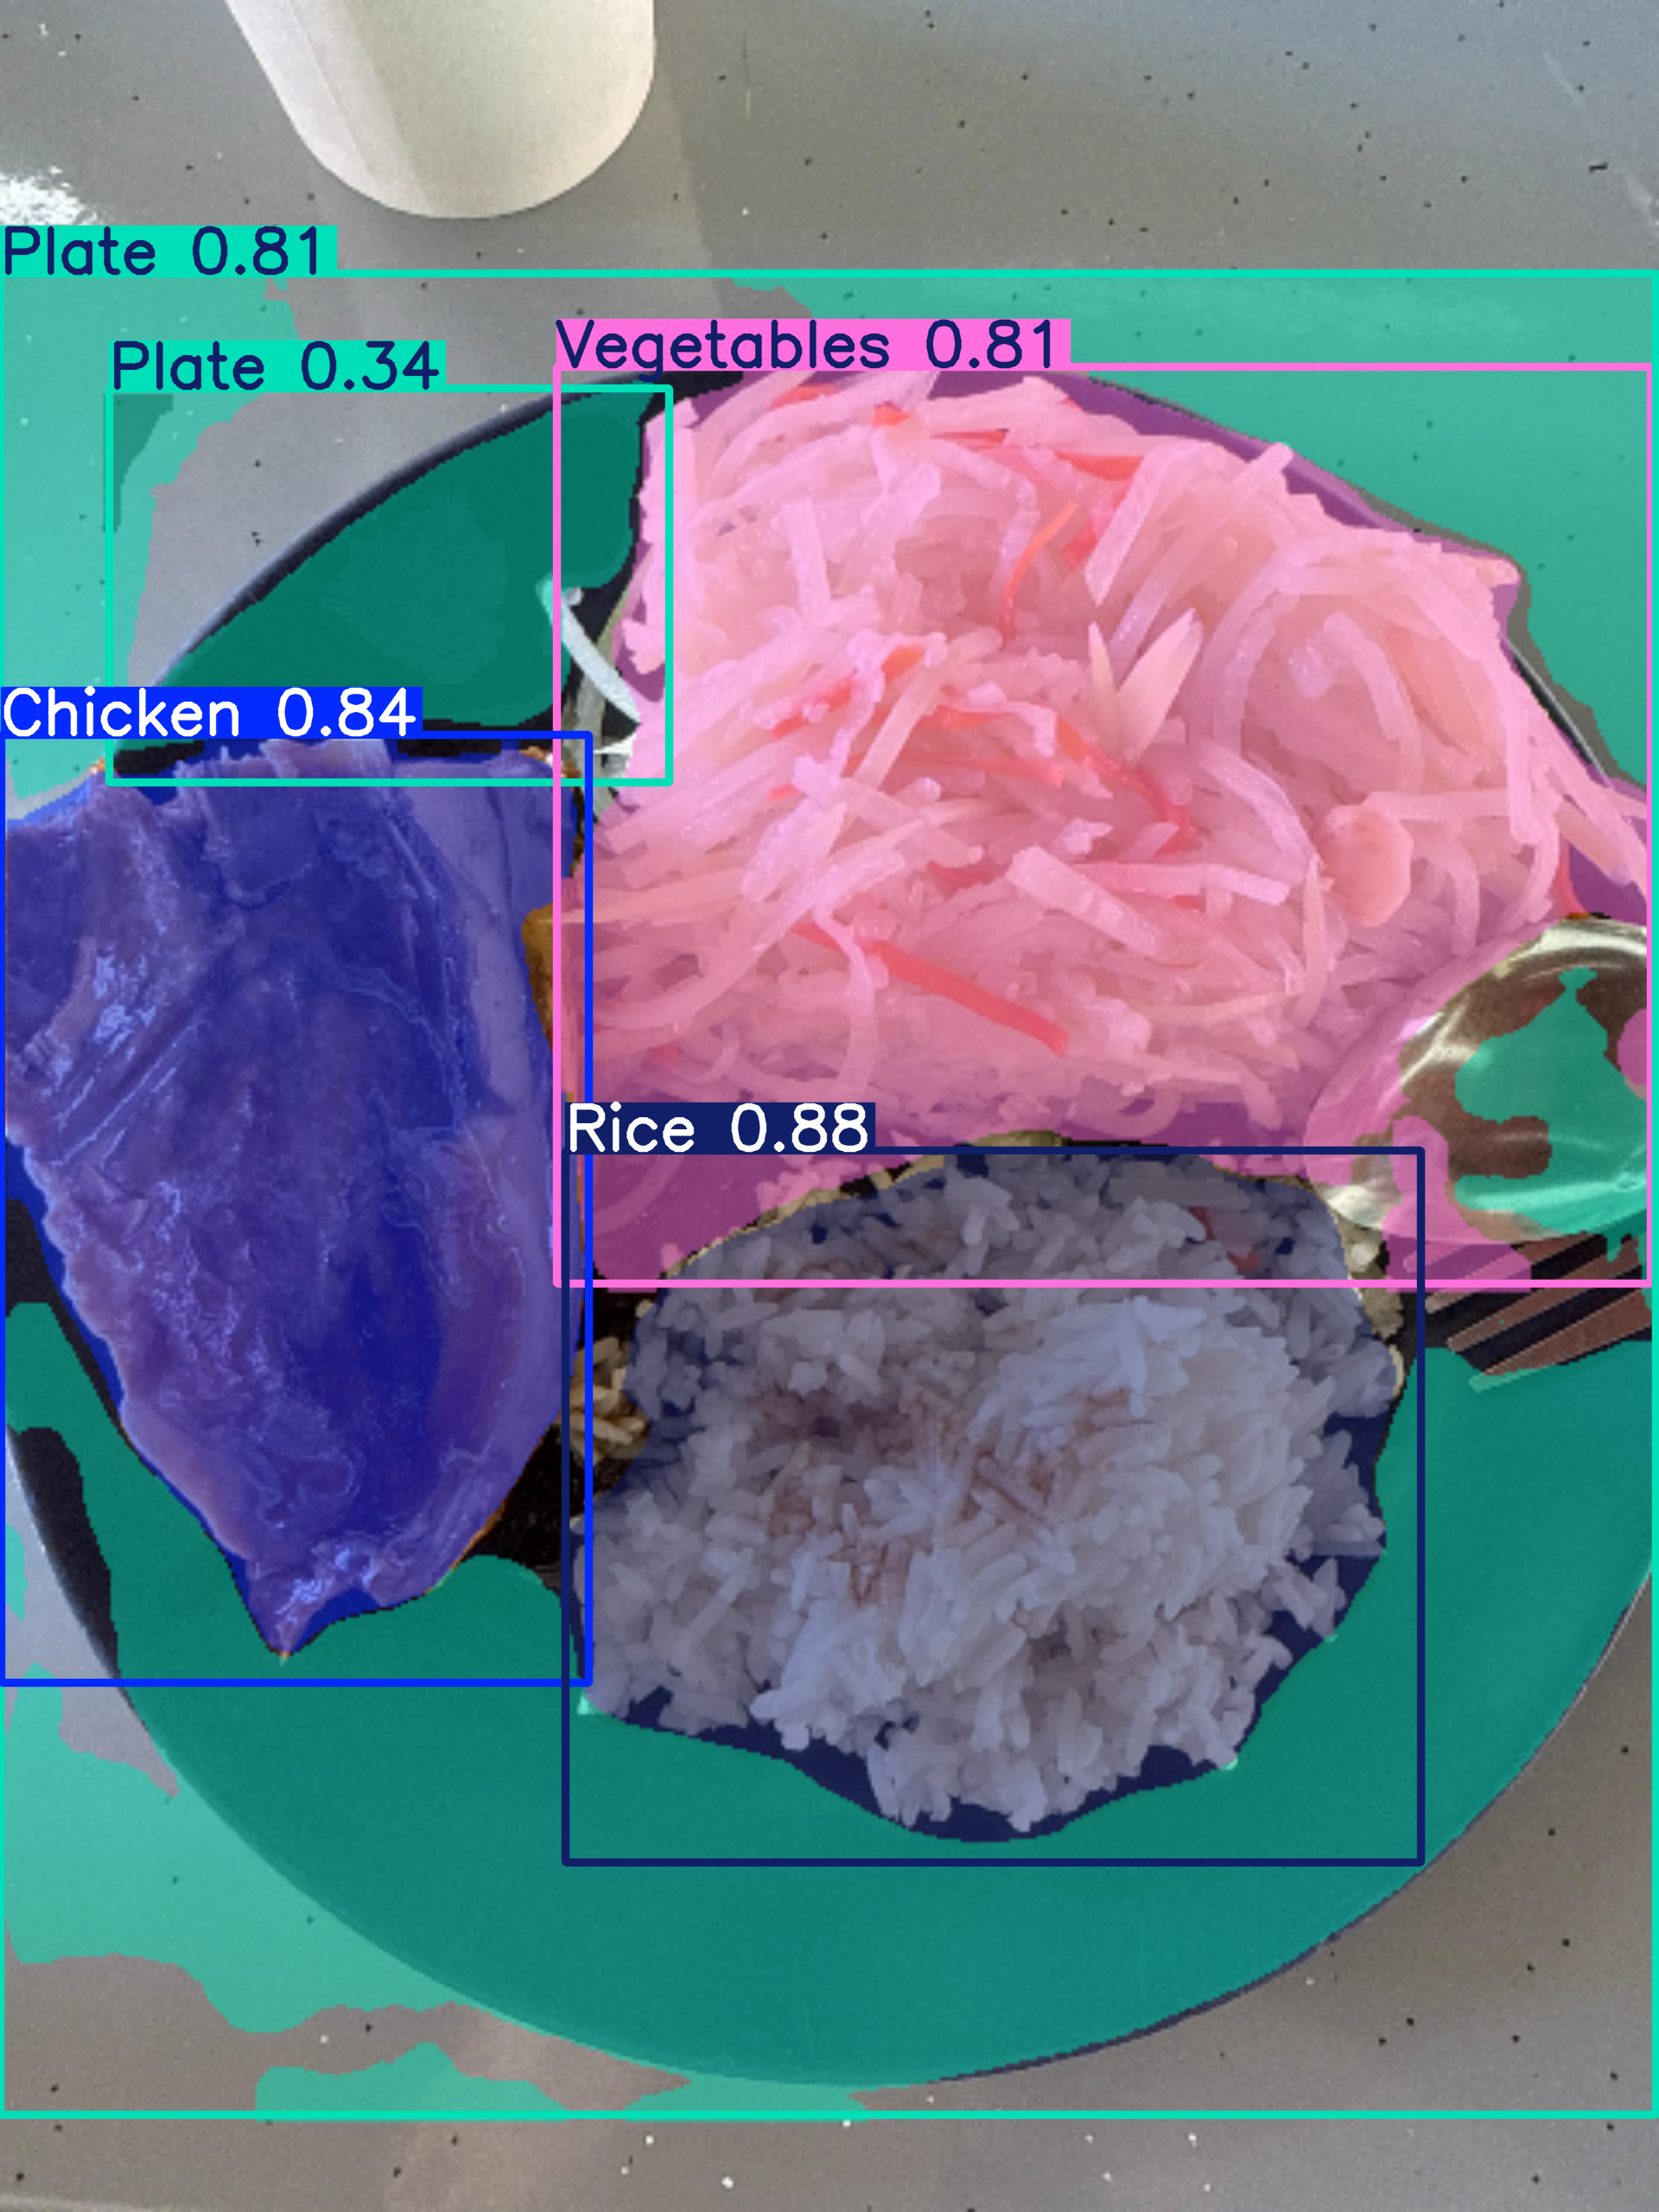

In [ ]:
# Make predictions on new images
results = model(
    Path('test-image/1.jpg').absolute())

# Show results
results[0].show()

In [ ]:
# Go through all detected classes and calculate their mask areas
for result in results:
    # Get the segmentation masks
    masks = result.masks
    if masks is None:
        print("No masks detected")
        continue

    # Get unique class IDs
    class_ids = result.boxes.cls.cpu().numpy().astype(int)
    class_names = [result.names[class_id] for class_id in class_ids]

    # Calculate area for each mask
    for i, (mask, class_id, class_name) in enumerate(zip(masks.data, class_ids, class_names)):
        # Convert mask to numpy array
        mask_array = mask.cpu().numpy()

        # Count non-zero pixels in the mask
        mask_area = np.count_nonzero(mask_array)

        # Optional: If you have the original image dimensions, you can calculate the area in pixels²
        # If your mask is already a binary mask (0 and 1), you can sum it up directly
        # mask_area = mask_array.sum()

        print(f"Class: {class_name}, ID: {class_id}, Area: {mask_area} pixels")

        # Optional: If you want to calculate area as a percentage of the image
        # total_pixels = mask_array.shape[0] * mask_array.shape[1]
        # area_percentage = (mask_area / total_pixels) * 100
        # print(f"Area percentage: {area_percentage:.2f}%")

Class: Rice, ID: 4, Area: 37126 pixels
Class: Chicken, ID: 0, Area: 34591 pixels
Class: Plate, ID: 3, Area: 80383 pixels
Class: Vegetables, ID: 5, Area: 60058 pixels
Class: Plate, ID: 3, Area: 7857 pixels


In [ ]:
def calculate_food_percentages(results):
    combined_mask = None
    plate_mask = None
    class_masks = {}
    area_results = {
        "total_area": 0,
        "class_areas": {},
        "class_percentages": {}
    }

    for result in results:
        # Get the segmentation masks
        masks = result.masks
        if masks is None:
            print("No masks detected")
            return area_results

        # Get class IDs and convert to class names
        class_ids = result.boxes.cls.cpu().numpy().astype(int)
        detected_class_names = [result.names[class_id] for class_id in class_ids]

        # Create an empty mask for combining all masks
        if combined_mask is None:
            # Get shape from first mask
            mask_shape = masks.data[0].shape
            combined_mask = np.zeros(mask_shape, dtype=bool)

        # Process each mask and combine same classes
        for i, (mask, class_name) in enumerate(zip(masks.data, detected_class_names)):
            # Convert mask to numpy boolean array
            mask_array = mask.cpu().numpy().astype(bool)

            # If class already exists, combine with OR operation
            if class_name in class_masks:
                class_masks[class_name] = np.logical_or(class_masks[class_name], mask_array)
            else:
                # Create new mask for class
                class_masks[class_name] = mask_array

            # Separately store plate mask
            if class_name == "Plate":
                if plate_mask is None:
                    plate_mask = mask_array.copy()
                else:
                    plate_mask = np.logical_or(plate_mask, mask_array)

    # Update combined mask after combining same classes
    combined_mask = np.zeros_like(class_masks[list(class_masks.keys())[0]], dtype=bool)
    for mask in class_masks.values():
        combined_mask = np.logical_or(combined_mask, mask)

    # Calculate the total area (sum of all masks)
    area_results["total_area"] = np.count_nonzero(combined_mask)

    # Calculate area for each food class and its percentage
    for class_name, mask in class_masks.items():
        # Calculate area
        class_area = np.count_nonzero(mask)
        area_results["class_areas"][class_name] = class_area

        # Calculate percentage of total area
        percentage = (class_area / area_results["total_area"]) * 100
        area_results["class_percentages"][class_name] = round(percentage, 2)

    return area_results

area_results = calculate_food_percentages(results)
area_results

{'total_area': 214240,
 'class_areas': {'Rice': 37126,
  'Chicken': 34591,
  'Plate': 82893,
  'Vegetables': 60058},
 'class_percentages': {'Rice': 17.33,
  'Chicken': 16.15,
  'Plate': 38.69,
  'Vegetables': 28.03}}

In [ ]:
def calculate_price(area_results):
    """
    Calculate the price of a meal based on the percentages of each food item.

    Pricing rules:
    - Rice: RM2 if > 10%
    - Chicken: RM4 per 20%
    - Fish: RM6 per 20%
    - Vegetables: RM2 per 20%
    - Prerequisite: Plate must exist

    Args:
        area_results: Dictionary containing the results from calculate_food_percentages

    Returns:
        Dictionary with price breakdown and total price
    """
    # Initialize price dictionary
    price_breakdown = {
        "Rice": 0,
        "Chicken": 0,
        "Fish": 0,
        "Vegetables": 0,
        "total": 0
    }

    # Check if plate exists
    if "Plate" not in area_results["class_percentages"]:
        return {"error": "Plate not detected", "total": 0}

    # Calculate price for each food item
    percentages = area_results["class_percentages"]

    # Rice: RM2 if > 10%
    if "Rice" in percentages and percentages["Rice"] > 10:
        price_breakdown["Rice"] = 2

    # Chicken: RM4 per 20%
    if "Chicken" in percentages:
        chicken_price = 4 * (percentages["Chicken"] / 20)
        price_breakdown["Chicken"] = round(chicken_price, 2)

    # Fish: RM6 per 20%
    if "Fish" in percentages:
        fish_price = 6 * (percentages["Fish"] / 20)
        price_breakdown["Fish"] = round(fish_price, 2)

    # Vegetables: RM2 per 20%
    if "Vegetables" in percentages:
        veg_price = 2 * (percentages["Vegetables"] / 20)
        price_breakdown["Vegetables"] = round(veg_price, 2)

    # Calculate total price
    price_breakdown["total"] = round(sum([
        price_breakdown["Rice"],
        price_breakdown["Chicken"],
        price_breakdown["Fish"],
        price_breakdown["Vegetables"]
    ]), 2)

    return price_breakdown


# Then, calculate the price
price_result = calculate_price(area_results)

# Print results
print("\nFood composition percentages:")
for class_name, percentage in area_results["class_percentages"].items():
    print(f"{class_name}: {percentage}%")

print("\nPrice breakdown:")
for item, price in price_result.items():
    if item != "total" and item != "error":
        print(f"{item}: RM{price:.2f}")

print(f"\nTotal price: RM{price_result['total']:.2f}")


Food composition percentages:
Rice: 17.33%
Chicken: 16.15%
Plate: 38.69%
Vegetables: 28.03%

Price breakdown:
Rice: RM2.00
Chicken: RM3.23
Fish: RM0.00
Vegetables: RM2.80

Total price: RM8.03
